## **Word2Vec with CBOW**

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
import tensorflow as tf
from keras.models import Sequential
import keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Lambda, Reshape, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## **Read Data**

In [4]:
data = pd.read_csv('data.txt')

In [5]:
data.head()

,1
0,ای رستخیز ناگهان، وی رحمت بی منتها\tای آتشی اف...
1,امروز خندان آمدی، مفتاح زندان آمدی\tبر مستمندا...
2,خورشید را حاجب تویی، امید را واجب تویی\tمطلب ت...
3,در سینه ها برخاسته، اندیشه را آراسته\tهم خویش ...
4,ای روح بخش بی بَدَل، وی لذتِ علم و عمل\tباقی ب...


**Read Stop-Words**

In [6]:
def read_stop_words(filename):
  with open(filename) as stopwords_file:
    stopwords = stopwords_file.readlines()
  stopwords = [line.replace('\n', '') for line in stopwords] 
  return stopwords

In [7]:
stopwords = read_stop_words('stopwords.txt')
print(len(stopwords))

1382


**hazm library**

In [8]:
# install hazm library
!pip install hazm
from hazm import word_tokenize

     |████████████████████████████████| 316 kB 4.9 MB/s 
     |████████████████████████████████| 233 kB 35.8 MB/s 
     |████████████████████████████████| 1.4 MB 39.8 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394485 sha256=30e7045f960854309a5a1a108fe10ebf8207d8cee09ece6c116f9a9114b03800
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154476 sha256=b0bfdbcc58536e8edee4fe9047648631e403fee7fbda2e74561760efa623f346
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


### **Preprocess the text**

In [9]:
# preprocess the text
def text_preprocess(data):
  text = [line.replace('\t', ' ') for line in data.values.flatten()]
  text = [line.replace('-', ' ') for line in text]
  text = [re.sub("\d+", "", t) for t in text]

  word_tokenized = [word_tokenize(t) for t in text]
  word_tokenized_filtered = [[w for w in sentence if w not in stopwords] for sentence in word_tokenized]

  sentences = [' '.join(sentence) for sentence in word_tokenized_filtered]
  sentences = [sentence for sentence in sentences if sentence != '']

  return sentences


In [10]:
sentences = text_preprocess(data)

In [11]:
sentences[0]

'رستخیز رحمت منتها آتشی افروخته بیشه اندیشه'

### **get less frequente words**

In [12]:
def get_all_sentences():
  all_sentences = ''
  sentences = text_preprocess(data)
  for sentence in sentences:
    all_sentences += sentence
    all_sentences += ' '

  return all_sentences  

In [13]:
def get_word_freq(vocabularies):
  word_freq = []
  for vocab in vocabularies:
    word_freq.append(vocabularies.count(vocab))
  return word_freq  

In [14]:
# get the words that frequentes less than 2 times in the corpus
def get_less_frequente_words():
  low_frequency_words = []
  all_sentences = get_all_sentences()
  vocabularies = all_sentences.split(' ')
  word_freq = get_word_freq(vocabularies)

  for i in range(len(word_freq)):
    if word_freq[i] < 2:
      low_frequency_words.append(vocabularies[i])

  return low_frequency_words

In [15]:
less_frequente_words = get_less_frequente_words()

In [16]:
print(len(less_frequente_words))

6366


## **remove less frequente words**

In [17]:
# remove the words that frequentes less than 2 times in the corpus
def remove_less_frequente_words(less_frequente_words, sentences):
  sentences_tokenized = [word_tokenize(sentence) for sentence in sentences]
  sentences_tokenized_filtered = [[w for w in sentence if w not in less_frequente_words] for sentence in sentences_tokenized]
  corpus = [' '.join(sentence) for sentence in sentences_tokenized_filtered]
  corpus = [sentence for sentence in corpus if sentence != '']

  return corpus

In [18]:
corpus = remove_less_frequente_words(less_frequente_words, sentences)

In [19]:
corpus[0:10]

['رستخیز رحمت منتها آتشی افروخته بیشه اندیشه',
 'خندان آمدی مفتاح زندان آمدی آمدی بخشش فضل خدا',
 'خورشید حاجب تویی امید واجب تویی مطلب تویی طالب تویی منتها',
 'سینه اندیشه آراسته حاجت روا',
 'روح علم باقی بهانه دغل علت دوا',
 'دغل کژ گنه کین مست مست نان شوربا',
 'هل عقل هل نان نشاید ماجرا',
 'تدبیر رنگ افکنی روم زنگ افکنی جنگ افکنی یری',
 'پنهان گوش جان بهانه کسان جان رب زنان والله کیا',
 'خامش رفتم پای علم کاغذ بنه بشکن قلم ساقی درآمد الصلا']

## **Tokenizer**

In [20]:
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [21]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [53]:
list(tokenizer.word_index.items())[0:15]

[('جان', 1),
 ('دل', 2),
 ('عشق', 3),
 ('آب', 4),
 ('چشم', 5),
 ('شب', 6),
 ('جهان', 7),
 ('شمس', 8),
 ('دست', 9),
 ('مست', 10),
 ('گل', 11),
 ('یار', 12),
 ('عقل', 13),
 ('جمله', 14),
 ('غم', 15)]

In [23]:
 # find more stopwords by sorting the tokenizer word counts
#  word_count_sorted = dict(sorted(tokenizer.word_counts.items(), reverse=False, key=lambda t: t[1]))
#  word_count_sorted

In [24]:
encoded = tokenizer.texts_to_sequences(corpus)

In [25]:
encoded[0:10]

[[2726, 283, 1337, 397, 1610, 967, 143],
 [185, 568, 1124, 398, 568, 568, 830, 332, 23],
 [46, 2727, 29, 636, 2031, 29, 831, 29, 258, 29, 1337],
 [92, 143, 1338, 727, 728],
 [30, 221, 162, 399, 1611, 968, 244],
 [1611, 729, 2032, 569, 10, 10, 209, 2728],
 [464, 13, 464, 209, 1125, 419],
 [969, 104, 1612, 352, 1126, 1612, 192, 1612, 730],
 [77, 41, 1, 399, 1613, 1, 259, 245, 284, 1127],
 [201, 731, 56, 221, 2729, 377, 732, 1128, 31, 570, 186]]

In [26]:
num_all_words = sum(len(s) for s in encoded) # total number of words in the corpus
num_unique_words = len(tokenizer.word_index) + 1  # total number of unique words in the corpus

In [27]:
num_all_words, num_unique_words

(32654, 4284)

### **Generate data**

In [28]:
# Parameters
window_size = 2

In [29]:
# CBOW
def generate_data(corpus, window_size, num_unique_words):
    all_inputs = []
    all_outputs = []

    for sentence in corpus:
        L = len(sentence)
        for index, word in enumerate(sentence):
            start = index - window_size
            end = index + window_size + 1

            context_words = []
            for i in range(start, end):
                if i != index:
                    if 0 <= i < L:
                        context_words.append(sentence[i])
                    else:
                        context_words.append(0)
            all_inputs.append(context_words)
            all_outputs.append(to_categorical(word, num_unique_words))
                 
    return (np.array(all_inputs), np.array(all_outputs))    

In [30]:
# Create training data
X_train, y_train = generate_data(encoded, window_size, num_unique_words)
X_train.shape, y_train.shape

((32654, 4), (32654, 4284))

In [31]:
X_train, y_train

(array([[   0,    0,  283, 1337],
        [   0, 2726, 1337,  397],
        [2726,  283,  397, 1610],
        ...,
        [   8,   22,  619, 1810],
        [  22,   24, 1810,    0],
        [  24,  619,    0,    0]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [32]:
# for i in X_train:
#   print(np.where(i == 1))
print(np.where(X_train[0] == 1))

(array([], dtype=int64),)


## **Create Neural Network**

In [33]:
model = Sequential()
model.add(Embedding(input_dim=num_unique_words, output_dim=50, input_length=window_size*2, embeddings_initializer='glorot_uniform'))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(50, )))
model.add(Dense(num_unique_words, activation='softmax', kernel_initializer='glorot_uniform'))

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 50)             214200    
                                                                 
 lambda (Lambda)             (None, 50)                0         
                                                                 
 dense (Dense)               (None, 4284)              218484    
                                                                 
Total params: 432,684
Trainable params: 432,684
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train, y_train, epochs=300, verbose=1, batch_size=128)

Epoch 1/300
256/256 [==============================] - 5s 18ms/step - loss: 8.1427 - accuracy: 0.0209
Epoch 2/300
256/256 [==============================] - 5s 18ms/step - loss: 7.6645 - accuracy: 0.0230
Epoch 3/300
256/256 [==============================] - 5s 18ms/step - loss: 7.5777 - accuracy: 0.0230
Epoch 4/300
256/256 [==============================] - 5s 19ms/step - loss: 7.5371 - accuracy: 0.0231
Epoch 5/300
256/256 [==============================] - 5s 18ms/step - loss: 7.5083 - accuracy: 0.0232
Epoch 6/300
256/256 [==============================] - 5s 18ms/step - loss: 7.4830 - accuracy: 0.0231
Epoch 7/300
256/256 [==============================] - 5s 18ms/step - loss: 7.4563 - accuracy: 0.0235
Epoch 8/300
256/256 [==============================] - 5s 18ms/step - loss: 7.4246 - accuracy: 0.0243
Epoch 9/300
256/256 [==============================] - 5s 19ms/step - loss: 7.3861 - accuracy: 0.0269
Epoch 10/300
256/256 [==============================] - 5s 18ms/step - loss: 7.341

### **Loss and Accuracy plot**

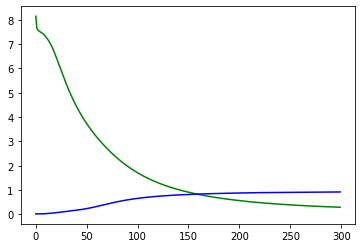

In [39]:
plt.plot(history.history['loss'], color='green', label='Loss')
plt.plot(history.history['accuracy'], color='blue', label='accuracy')

In [40]:
model.save('word2vec.h5')

## **Load Model**

In [41]:
# laod model
model = load_model('word2vec.h5')

In [42]:
model

In [43]:
weights = model.get_weights()

In [44]:
weights[0][1]

array([ 1.8212957 ,  0.30798614, -1.5770972 ,  0.6195138 ,  0.46113226,
       -1.0850326 , -1.5585592 ,  0.6005408 ,  0.8289619 , -1.4800417 ,
       -0.49123228, -0.7261426 , -0.15095983,  0.2454091 , -0.04197242,
        0.6444775 , -0.6405439 ,  0.7550058 ,  0.83351177,  1.0177284 ,
        0.30975813, -2.5754516 , -0.18166237, -1.6441044 ,  0.18483934,
       -3.3331501 , -0.36649308,  3.0233157 ,  2.4002042 ,  0.37174973,
        1.3382609 , -1.5898685 ,  1.8035638 , -2.5048563 , -0.02682108,
       -0.56691843, -0.7731482 , -0.21949543,  0.93925315,  2.597449  ,
        2.4126701 , -1.4621407 ,  1.4653767 , -0.31707886,  2.5772147 ,
        0.62155014, -1.970795  , -2.4434478 ,  1.9304849 , -0.05640695],
      dtype=float32)

In [45]:
with open('tokenizer.h5', 'rb') as f:
    tokenizer = pickle.load(f)

In [46]:
model.predict([[696,697,699,700]])

array([[3.7305899e-18, 2.9325605e-07, 9.7689037e-05, ..., 3.9029084e-12,
        7.8051662e-12, 1.0194475e-17]], dtype=float32)